<i>Copyright (c) Recommenders contributors.</i>

<i>Licensed under the MIT License.</i>

# Estimating Baseline Performance
<br>
Estimating baseline performance is as important as choosing right metrics for model evaluation. In this notebook, we briefly discuss about why do we care about baseline performance and how to measure it.

The notebook covers two example scenarios under the context of movie recommendation: 1) rating prediction and 2) top-k recommendation.

### Why does baseline performance matter?
<br>
Before we go deep dive into baseline performance estimation, it is worth to think about why we need that.

As we can simply see from the definition of the word 'baseline', <b>baseline performance</b> is a minimum performance we expect to achieve by a model or starting point used for model comparisons.

Once we train a model and get results from evaluation metrics we choose, we will wonder how should we interpret the metrics or even wonder if the trained model is better than a simple rule-based model. Baseline results help us to understand those.

Let's say we are building a food recommender. We evaluated the model on the test set and got nDCG (at 10) = 0.3. At that moment, we would not know if the model is good or bad. But once we find out that a simple rule of <i>'recommending top-10 most popular foods to all users'</i> can achieve nDCG = 0.4, we see that our model is not good enough. Maybe the model is not trained well, or maybe we should think about if nDCG is the right metric for prediction of user behaviors in the given problem.

## **Import libraries**

In [99]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import time
import datetime
import random
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm
from numpy import dot
from numpy import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## **Read dataset**

In [100]:
ratings = pd.read_csv('/content/dataset_final.csv')
ratings

,User_name,Location_hotel,Hotel_name,Rating,Comment,Service,Infrastructure,Sanitary,Location,Attitude
0,Nguyen V. C.,Phan Thiết,Khu nghỉ dưỡng Pandanus Phan Thiết,10.0,tôi đặt cho gia_đình của tôi đi nghe nói mọi t...,0,0,0,0,2
1,Nguyen T. A. T.,Phú Quốc,Vinpearl Resort & Spa Phú Quốc,8.5,khách_sạn có dịch_vụ tốt thủ_tục nhanh gọn nhâ...,1,0,0,0,2
2,Tran T. M. T.,Phan Thiết,Victoria Phan Thiết Beach Resort & Spa,9.0,victoria phan_thiết rất tốt tôi không_có_gì ph...,0,0,0,0,2
3,Dang T. D.,Đà Lạt,Khách Sạn LADALAT,6.0,khách_sạn hơi xa trung_tâm phòng_ốc tốt buffet...,1,1,0,1,1
4,Nguyen T. M. H.,Phan Thiết,Sea Links Beach Villas Phan Thiết,8.7,tốt khâu xếp_hàng từ bãi biển hơi có người sắp...,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...
2226,Do T. H.,Đà Nẵng,Khu nghỉ dưỡng Núi Thần Tài Ebisu Đà Nẵng,8.0,nhân_viên nhiệt_tình phòng thoáng rộng nhưng t...,1,1,0,0,2
2227,Nguyen T. T. H.,Huế,Hong Thien 1 Hotel,6.0,đồ ăn sáng không_ngon phòng có mùi khó_chịu và...,1,0,1,0,0
2228,Phan T. L.,Phan Thiết,Khu nghỉ dưỡng Muine Bay Phan Thiết,10.0,nói_chung là chuyến đi rất tốt tôi không_có_gì...,1,0,0,0,2
2229,Nguyen T. M. C.,Phan Thiết,Khu nghỉ dưỡng Pandanus Phan Thiết,9.0,dịch_vụ ăn_uống và phòng_ốc của khách_sạn đều ...,1,1,0,0,2


<Figure size 1200x800 with 0 Axes>

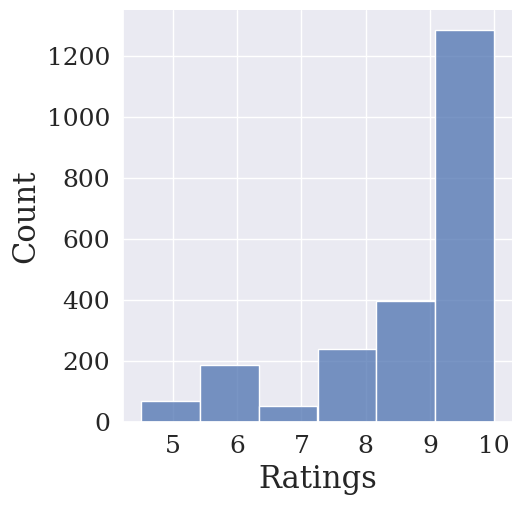

In [101]:
plt.figure(figsize=(12, 8))
sns.displot(x=ratings["Rating"],bins=6)

plt.xlabel('Ratings', fontsize=22, fontfamily='serif')
plt.ylabel('Count', fontsize=22, fontfamily='serif')

plt.xticks(fontsize=18, fontfamily='serif')
plt.yticks(fontsize=18, fontfamily='serif')

plt.show()

## **Preprocess Data**

In [102]:
ratings = ratings.loc[:,['User_name','Hotel_name','Service',	'Infrastructure',	'Sanitary',	'Location',	'Attitude', 'Rating']]
ratings

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating
0,Nguyen V. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,0,0,0,0,2,10.0
1,Nguyen T. A. T.,Vinpearl Resort & Spa Phú Quốc,1,0,0,0,2,8.5
2,Tran T. M. T.,Victoria Phan Thiết Beach Resort & Spa,0,0,0,0,2,9.0
3,Dang T. D.,Khách Sạn LADALAT,1,1,0,1,1,6.0
4,Nguyen T. M. H.,Sea Links Beach Villas Phan Thiết,0,0,0,0,2,8.7
...,...,...,...,...,...,...,...,...
2226,Do T. H.,Khu nghỉ dưỡng Núi Thần Tài Ebisu Đà Nẵng,1,1,0,0,2,8.0
2227,Nguyen T. T. H.,Hong Thien 1 Hotel,1,0,1,0,0,6.0
2228,Phan T. L.,Khu nghỉ dưỡng Muine Bay Phan Thiết,1,0,0,0,2,10.0
2229,Nguyen T. M. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,1,1,0,0,2,9.0


In [103]:
# tokenize User_name, Hotel_name
user_ids = ratings["User_name"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}

hotel_ids = ratings["Hotel_name"].unique().tolist()
hotel2hotel_encoded = {x: i for i, x in enumerate(hotel_ids)}
hotel_encoded2hotel = {i: x for i, x in enumerate(hotel_ids)}

ratings["UserID"] = ratings["User_name"].map(user2user_encoded)
ratings["HotelID"] = ratings["Hotel_name"].map(hotel2hotel_encoded)

num_users = len(user2user_encoded)
num_hotels = len(hotel2hotel_encoded)
ratings["Rating"] = ratings["Rating"].values.astype(np.float32)

min_rating = min(ratings["Rating"])
max_rating = max(ratings["Rating"])

print("Number of users: {}, Number of hotels: {}, Min rating: {}, Max rating: {}".format(num_users, num_hotels, min_rating, max_rating))

Number of users: 368, Number of hotels: 137, Min rating: 4.5, Max rating: 10.0


In [104]:
ratings

,User_name,Hotel_name,Service,Infrastructure,Sanitary,Location,Attitude,Rating,UserID,HotelID
0,Nguyen V. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,0,0,0,0,2,10.0,0,0
1,Nguyen T. A. T.,Vinpearl Resort & Spa Phú Quốc,1,0,0,0,2,8.5,1,1
2,Tran T. M. T.,Victoria Phan Thiết Beach Resort & Spa,0,0,0,0,2,9.0,2,2
3,Dang T. D.,Khách Sạn LADALAT,1,1,0,1,1,6.0,3,3
4,Nguyen T. M. H.,Sea Links Beach Villas Phan Thiết,0,0,0,0,2,8.7,4,4
...,...,...,...,...,...,...,...,...,...,...
2226,Do T. H.,Khu nghỉ dưỡng Núi Thần Tài Ebisu Đà Nẵng,1,1,0,0,2,8.0,255,47
2227,Nguyen T. T. H.,Hong Thien 1 Hotel,1,0,1,0,0,6.0,181,54
2228,Phan T. L.,Khu nghỉ dưỡng Muine Bay Phan Thiết,1,0,0,0,2,10.0,263,29
2229,Nguyen T. M. C.,Khu nghỉ dưỡng Pandanus Phan Thiết,1,1,0,0,2,9.0,159,0


In [105]:
# # Normalize rating vào khoảng [0, 1]
# ratings["Rating"] = ratings["Rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

In [109]:
ratings = ratings[['UserID', 'HotelID', 'Rating']]

### How can we estimate the baseline performance?
<br>
To estimate the baseline performance, we first pick a baseline model and evaluate it by using the same evaluation metrics we will use for our main model. In general, a very simple rule or even <b>zero rule</b>--<i>predicts the mean for regression or the mode for classification</i>--will be a enough as a baseline model (Random-prediction might be okay for certain problems, but usually it performs poor than the zero rule). If we already have a running model in hand and now trying to improve that, we can use the previous results as a baseline performance for sure.

Most importantly, <b>different baseline approaches should be taken for different problems and business goals</b>. For example, recommending the previously purchased items could be used as a baseline model for food or restaurant recommendation since people tend to eat the same foods repeatedly. For TV show and/or movie recommendation, on the other hand, recommending previously watched items does not make sense. Probably recommending the most popular (most watched or highly rated) items is more likely useful as a baseline.

In this notebook, we demonstrate how to estimate the baseline performance for the movie recommendation with MovieLens dataset. We use the mean for rating prediction, i.e. our baseline model will predict a user's rating of a movie by averaging the ratings the user previously submitted for other movies. For the top-k recommendation problem, we use top-k most-rated movies as the baseline model. We choose the number of ratings here because we regard the binary signal of 'rated vs. not-rated' as user's implicit preference when evaluating ranking metrics.

Now, let's jump into the implementation!

In [110]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [111]:
%cd /content/drive/MyDrive/Colab_me/DS300/recommenders/

/content/drive/MyDrive/Colab_me/DS300/recommenders


In [112]:
# !pip install scrapbook
# !pip install papermill
# !pip install cornac
# !pip install retrying
# !pip install pandera

In [113]:
import sys

import itertools
import pandas as pd
import scrapbook as sb

from recommenders.utils.notebook_utils import is_jupyter
# from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.datasets.pandas_df_utils import filter_by
from recommenders.evaluation.python_evaluation import (
    rmse, mae, rsquared, exp_var,
    map_at_k, ndcg_at_k, precision_at_k, recall_at_k
)

print(f"System version: {sys.version}")
print(f"Pandas version: {pd.__version__}")

System version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas version: 1.5.3


First, let's prepare training and test data sets.

In [114]:
TOP_K = 10

In [115]:
data = ratings[['UserID', 'HotelID', 'Rating']]
data = data.rename(columns={'UserID': "userID", 'HotelID': "itemID", 'Rating': "rating"})

data.head()

,userID,itemID,rating
0,0,0,10.0
1,1,1,8.5
2,2,2,9.0
3,3,3,6.0
4,4,4,8.7


In [116]:
train, test = python_random_split(data, ratio=0.8, seed=42)

In [117]:
train

,userID,itemID,rating
1988,168,71,10.0
1996,363,57,7.0
1581,302,56,9.7
1904,4,67,9.7
1426,248,83,10.0
...,...,...,...
1638,63,1,8.0
1095,4,55,8.5
1130,216,65,10.0
1294,338,0,10.0


### 1. Rating prediction baseline

As we discussed earlier, we use each user's **mean rating** as the baseline prediction.

In [118]:
# Calculate avg ratings from the training set
users_ratings = train.groupby(["userID"])["rating"].mean()
users_ratings = users_ratings.to_frame().reset_index()
users_ratings.rename(columns={"rating": "AvgRating"}, inplace=True)

users_ratings.head()

,userID,AvgRating
0,0,7.75
1,1,8.11
2,2,9.60
3,3,8.00
4,4,8.71


In [119]:
# Generate prediction for the test set
baseline_predictions = pd.merge(test, users_ratings, on=["userID"], how="inner")

baseline_predictions.loc[baseline_predictions["userID"] == 1].head()

,userID,itemID,rating,AvgRating
404,1,1,10.0,8.11


Now, let's evaluate how our baseline model will perform on regression metrics

In [120]:
baseline_predictions = baseline_predictions[["userID", "itemID", "AvgRating"]]

cols = {
    "col_user": "userID",
    "col_item": "itemID",
    "col_rating": "rating",
    "col_prediction": "AvgRating",
}

eval_rmse = rmse(test, baseline_predictions, **cols)
eval_mae = mae(test, baseline_predictions, **cols)
eval_rsquared = rsquared(test, baseline_predictions, **cols)
eval_exp_var = exp_var(test, baseline_predictions, **cols)

print("RMSE:\t\t%f" % eval_rmse,
      "MAE:\t\t%f" % eval_mae,
      "rsquared:\t%f" % eval_rsquared,
      "exp var:\t%f" % eval_exp_var, sep='\n')

RMSE:		1.554641
MAE:		1.174377
rsquared:	-0.212546
exp var:	-0.210753


As you can see, our baseline model actually performed quite well on the metrics. E.g. MAE (Mean Absolute Error) was around 0.84 on MovieLens 100k data, saying that users actual ratings would be within +-0.84 of their mean ratings. This also gives us an insight that users' rating could be biased where some users tend to give high ratings for all movies while others give low ratings.

Now, next time we build our machine-learning model, we will want to make the model performs better than this baseline.

### 2. Top-k recommendation baseline

Recommending the **most popular items** is intuitive and simple approach that works for many of recommendation scenarios. Here, we use top-k most-rated movies as the baseline model as we discussed earlier.

In [121]:
item_counts = train["itemID"].value_counts().to_frame().reset_index()
item_counts.columns = ["itemID", "Count"]
item_counts.head()

,itemID,Count
0,8,98
1,0,89
2,2,61
3,3,45
4,5,43


In [122]:
user_item_col = ["userID", "itemID"]

# Cross join users and items
test_users = test['userID'].unique()
user_item_list = list(itertools.product(test_users, item_counts['itemID']))
users_items = pd.DataFrame(user_item_list, columns=user_item_col)

print("Number of user-item pairs:", len(users_items))

# Remove seen items (items in the train set) as we will not recommend those again to the users
users_items_remove_seen = filter_by(users_items, train, user_item_col)

print("After remove seen items:", len(users_items_remove_seen))

Number of user-item pairs: 31860
After remove seen items: 30734


In [127]:
# Generate recommendations
baseline_recommendations = pd.merge(item_counts, users_items_remove_seen, on=['itemID'], how='inner')
baseline_recommendations.head()

,itemID,Count,userID
0,8,98,20
1,8,98,300
2,8,98,221
3,8,98,249
4,8,98,241


In [128]:
cols["col_prediction"] = "Count"

eval_map = map_at_k(test, baseline_recommendations, k=TOP_K, **cols)
eval_ndcg_10 = ndcg_at_k(test, baseline_recommendations, k=10, **cols)
eval_ndcg_5 = ndcg_at_k(test, baseline_recommendations, k=5, **cols)
eval_precision_10 = precision_at_k(test, baseline_recommendations, k=10, **cols)
eval_precision_5 = precision_at_k(test, baseline_recommendations, k=5, **cols)
eval_recall_10 = recall_at_k(test, baseline_recommendations, k=10, **cols)
eval_recall_5 = recall_at_k(test, baseline_recommendations, k=5, **cols)

print("MAP:\t%f" % eval_map,
      "NDCG@10:\t%f" % eval_ndcg_10,
      "NDCG@5:\t%f" % eval_ndcg_5,
      "Precision@10:\t%f" % eval_precision_10,
      "Precision@5:\t%f" % eval_precision_5,
      "Recall@10:\t%f" % eval_recall_10,
      "Recall@5:\t%f" % eval_recall_5,sep='\n')

MAP:	0.071961
NDCG@10:	0.114127
NDCG@5:	0.086801
Precision@10:	0.036441
Precision@5:	0.038136
Recall@10:	0.182461
Recall@5:	0.101100


Again, the baseline is quite high, nDCG = 0.25 and Precision = 0.22.

<br>

### Concluding remarks

In this notebook, we discussed how to measure baseline performance for the movie recommendation example.
We covered very naive approaches as baselines, but still they are useful in a sense that they can provide reference numbers to estimate the complexity of the given problem as well as the relative performance of the recommender models we are building.

In [125]:
if is_jupyter():
    # Record results with papermill and scrapbook for tests
    sb.glue("map", eval_map)
    sb.glue("ndcg", eval_ndcg)
    sb.glue("precision", eval_precision)
    sb.glue("recall", eval_recall)
    sb.glue("rmse", eval_rmse)
    sb.glue("mae", eval_mae)
    sb.glue("exp_var", eval_exp_var)
    sb.glue("rsquared", eval_rsquared)

### References

[[1](https://dl.acm.org/citation.cfm?id=1401944)] Yehuda Koren,	Factorization meets the neighborhood: a multifaceted collaborative filtering model, KDD '08 pp. 426-434 2008.  
[[2](https://surprise.readthedocs.io/en/stable/basic_algorithms.html)] Surprise lib, Basic algorithms